## Order-flow Analysis in Limit Order Books

We investigate whether features derived from buying/selling pressure as well as trade-execution in Limit Order Books have the potential to be exploited as trading-signals. We use datasets from [LOBSTER]([https://lobsterdata.com/) and train a simple multi-variate linear model which is then used to back-test our strategy.

This is based on the ideas [here]( http://eprints.maths.ox.ac.uk/1895/1/Darryl%20Shen%20%28for%20archive%29.pdf). 

My feel is that it probably won't work well, but this is just something to get a feel of things in orderbook flow stuff. Another problem is that we have very limited data as well.

See related stuff here, 

1. http://epchan.blogspot.com/2018/02/fx-order-flow-as-predictor.html
2. http://www.pnas.org/content/pnas/102/6/2254.full.pdf
3. https://arxiv.org/pdf/1012.0349.pdf
4. https://pdfs.semanticscholar.org/7b7b/25570b8bedfc4d7d3573c8d7f907119aa2a6.pdf


In [19]:
import datetime
from   itertools import izip
import time
import warnings

import matplotlib.pyplot as plt
from   numba import jit
import numpy as np
from   numpy.linalg import pinv
import pandas as pd
import pytz
from   scipy.optimize import basinhopping
from   scipy.stats import zscore
import seaborn as sns
import statsmodels.api as sm
from   statsmodels.graphics.tsaplots import plot_acf
from   statsmodels.tsa.stattools import acf

warnings.filterwarnings('ignore')
%matplotlib inline

from itertools import izip, tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return izip(a, b)

In [20]:
msg_filename       = './AAPL_2012-06-21_message_50.csv'
orderbook_filename = './AAPL_2012-06-21_orderbook_50.csv'

First we parse both the message and the orderbook CSV files from LOBSTER into a pandas dataframe so that we can easily manipulate it.

In [21]:
rows = []
with open(orderbook_filename) as f1:
    with open(msg_filename) as f2:
        for line1, line2 in izip(f1, f2):
            askp, askv, bidp, bidv = line1.strip().split(',',4)
            ts, evt, _, vol, price, side = line2.strip().split(',')

            ts = float(ts)
            bidp, bidv, askp, askv, vol, price, side = \
                map(int, [bidp, bidv, askp, askv, vol, price, side]) 

            if not evt in ['4', '5']:
                price = vol = side = 0
                
            row = (pd.Timestamp.fromtimestamp(ts), bidp, bidv, askp, askv, price, vol, side)
            rows.append(row)
            
columns =  ['ts', 'bid', 'bid_vol', 'ask', 'ask_vol', 'trade', 'trade_vol', 'trade_side']

split = 52000

rows_train, rows_test = rows[:split], rows[split:]
#rows_test, rows_train = rows[-split:], rows[:-split] #swap

def make_df(rows):
    df = pd.DataFrame(rows, columns=columns)
    df.set_index('ts', inplace=True)
    df.sort_index(inplace=True)
    df['spread'] = df['ask'] - df['bid']

    df['bid_vol_delta'] = df['bid_vol'].diff()
    df['ask_vol_delta'] = df['ask_vol'].diff()
    df['bid_delta'] = df['bid'].diff() / df['spread']
    df['ask_delta'] = df['ask'].diff() / df['spread']
    df['mid'] = ( df['bid'] + df['ask'] ) / 2.
    df['mid_delta'] = df['mid'].diff()
    
    return df

df      = make_df(rows_train)
df_test = make_df(rows_test)

In [34]:
df.head()

,bid,bid_vol,ask,ask_vol,trade,trade_vol,trade_side,spread,bid_vol_delta,ask_vol_delta,bid_delta,ask_delta,mid,mid_delta,order_imba
ts,,,,,,,,,,,,,,,
1970-01-01 17:00:00.004241,5853300,18,5859400,200,0,0,0,6100,NaN,NaN,NaN,NaN,5856350.0,NaN,NaN
1970-01-01 17:00:00.004261,5853300,18,5859400,200,0,0,0,6100,0.0,0.0,0.0,0.000000,5856350.0,0.0,NaN
1970-01-01 17:00:00.004447,5853300,18,5859400,200,0,0,0,6100,0.0,0.0,0.0,0.000000,5856350.0,0.0,0.000000
1970-01-01 17:00:00.025552,5853300,18,5859100,18,0,0,0,5800,0.0,-182.0,0.0,-0.051724,5856200.0,-150.0,-0.000086
1970-01-01 17:00:00.025580,5853300,18,5859100,18,0,0,0,5800,0.0,0.0,0.0,0.000000,5856200.0,0.0,0.000000


Next we show a quick sampling of the data in both tabular as well as graphical form.

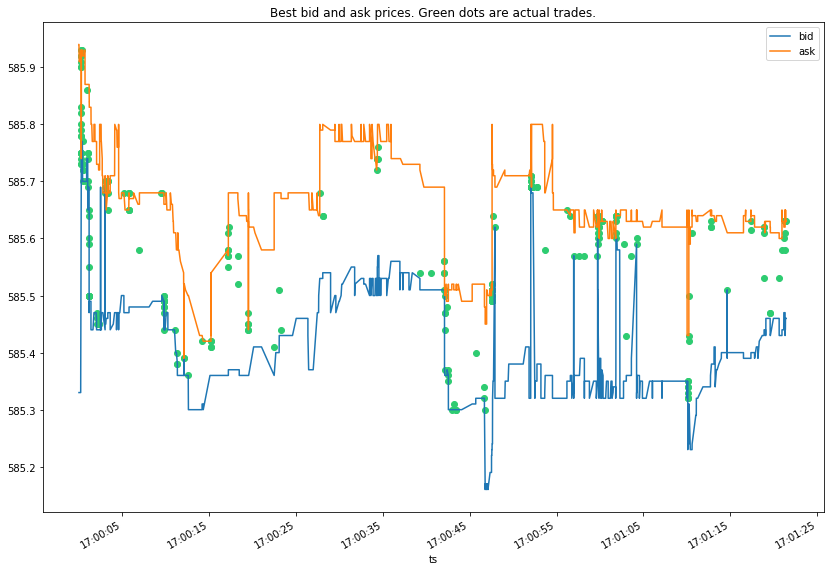

In [35]:
df_sample = df[:2000]/10000.

df_sample.plot(y=['bid', 'ask'], figsize=(14,10), 
               title='Best bid and ask prices. Green dots are actual trades.', use_index=True)

trades = df_sample[df_sample['trade'] > 0] 
plt.scatter(trades.index, trades.trade, c='#2ECC71', label='adfa')

plt.show()

Next we calculate buy/sell pressure indicator based on, 
1. volume changes.
2. trade-execution volumes.

In [36]:
def calc_order_imba(df):

    it = iter(df.iterrows())
    it.next() # skip first row 

    order_imba = []
    weight = 1. # we weight execution volume more since from empirical evidence
                # close to 90% of orders in LOBs are cancelled.

    # feature engineering...
    for (_, prev_row), (_, cur_row) in pairwise(it):

        delvol_bid = 0
        delvol_ask = 0

        if cur_row.trade_vol > 0:
            if cur_row.trade_side == 1: 
                # some seller crossed the spread to take the best bid, must give a -ve indicator
                delvol_ask = cur_row.trade_vol * weight
            else:
                # some buy crossed the spread to take the best ask, must give a +ve indicator
                delvol_bid = cur_row.trade_vol * weight

        else:
            if cur_row.bid > prev_row.bid:
                delvol_bid = cur_row.bid_vol
            elif cur_row.bid == prev_row.bid:
                delvol_bid = cur_row.bid_vol_delta
            elif cur_row.bid < prev_row.bid: 
                # the best bid decreased, due to withdrawal of bid.
                delvol_bid = -prev_row.bid_vol

            if cur_row.ask < prev_row.ask:
                delvol_ask = cur_row.ask_vol
            elif cur_row.ask == prev_row.ask:
                delvol_ask = cur_row.ask_vol_delta
            elif cur_row.ask > prev_row.ask:
                delvol_ask = -prev_row.ask_vol

        imba = ( delvol_bid - delvol_ask ) / ( cur_row.bid_vol + cur_row.ask_vol )        
        order_imba.append( imba / cur_row.spread)

    df['order_imba'] = [np.nan]*2 + order_imba

calc_order_imba(df)

We show next what the first few rows look like with the indicator populated.

In [38]:
df.head()

,bid,bid_vol,ask,ask_vol,trade,trade_vol,trade_side,spread,bid_vol_delta,ask_vol_delta,bid_delta,ask_delta,mid,mid_delta,order_imba
ts,,,,,,,,,,,,,,,
1970-01-01 17:00:00.004241,5853300,18,5859400,200,0,0,0,6100,NaN,NaN,NaN,NaN,5856350.0,NaN,NaN
1970-01-01 17:00:00.004261,5853300,18,5859400,200,0,0,0,6100,0.0,0.0,0.0,0.000000,5856350.0,0.0,NaN
1970-01-01 17:00:00.004447,5853300,18,5859400,200,0,0,0,6100,0.0,0.0,0.0,0.000000,5856350.0,0.0,0.000000
1970-01-01 17:00:00.025552,5853300,18,5859100,18,0,0,0,5800,0.0,-182.0,0.0,-0.051724,5856200.0,-150.0,-0.000086
1970-01-01 17:00:00.025580,5853300,18,5859100,18,0,0,0,5800,0.0,0.0,0.0,0.000000,5856200.0,0.0,0.000000


Also next a quick EDA to see if there's some relationship between the 'mid_delta', which is the change in mid quote, against 'order_imba', which is the buy/sell pressure indicator we've computed. But first we aggregate the explanatory and response variable into 5-second buckets. We then plot the winsorized data (at top 1% on both ends) with the least square regression line.

In [39]:
freq = '5s'

def grp_func(sub_df):
    m = sub_df['mid_delta'].sum()
    o = sub_df['order_imba'].sum()

    return pd.DataFrame({'order_imba':[o], 'mid_delta':[m]})

per_sec_data = df.groupby(pd.Grouper(level='ts', freq=freq)).apply(grp_func)
per_sec_data.dropna(inplace=True)

In [40]:
def reject_outliers(x, y, m=2.):
    idx = np.abs(x - np.mean(x)) < m * np.std(x)
    return x[idx], y[idx]

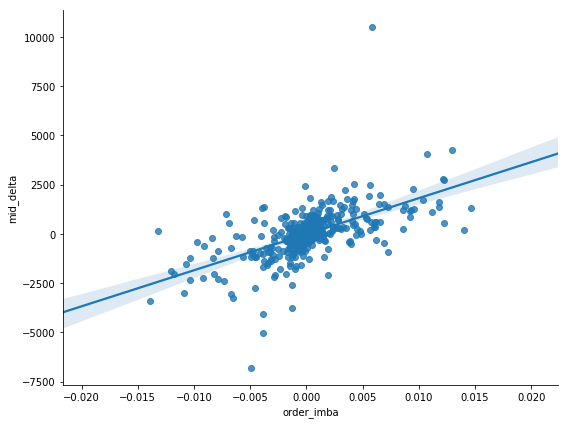

In [41]:
height = 6.0
aspect = 4./3.

win_x, win_y = reject_outliers(per_sec_data.order_imba, per_sec_data.mid_delta)
plot_df = pd.DataFrame({'order_imba':win_x, 'mid_delta':win_y})
sns.lmplot(x='order_imba',y='mid_delta',data=plot_df,fit_reg=True, size=height, aspect=aspect) 
plt.show()

A cursory examination also shows some significance in the lag-1 acf. This means that positive pressure indicator at time-$t$ tends to be $+$ve if the one at time-$(t-1)$ is also $+$ve. See the acf plot below.

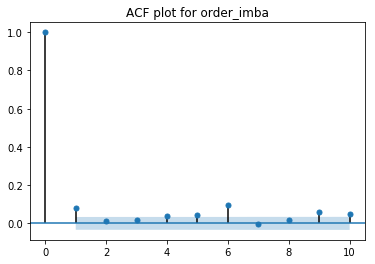

In [42]:
_=plot_acf(per_sec_data.order_imba, lags = 10, alpha=0.5, title='ACF plot for order_imba')

The same observation is present also for the mid_delta.

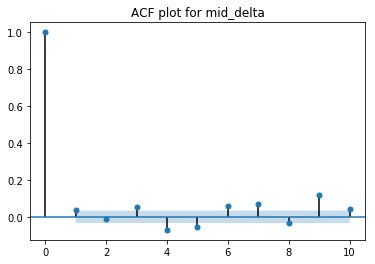

In [43]:
_=plot_acf(per_sec_data.mid_delta, lags = 10, alpha=0.5, title='ACF plot for mid_delta')

We next perform further processing to test if the value of the pressure indicator has predictive power on the average mid price change in the next 3 secs. We also add additional regressors, which is the lag-1 order_imba indicator.

In [44]:
forecast_df = df.groupby(pd.Grouper(level='ts', freq=freq)).apply(grp_func)

In [45]:
forecast_df['mid_predict_next'] = forecast_df['mid_delta'].shift(-1) 
forecast_df['order_imba_1']     = forecast_df['order_imba'].shift(1) 
forecast_df['order_imba_2']     = forecast_df['order_imba'].shift(2) 
forecast_df.dropna(inplace=True)

In [46]:
forecast_df.head()

,,mid_delta,order_imba,mid_predict_next,order_imba_1,order_imba_2
ts,,,,,,
1970-01-01 17:00:10,0,-1900.0,-0.012015,1300.0,0.000237,0.019479
1970-01-01 17:00:15,0,1300.0,0.014658,650.0,-0.012015,0.000237
1970-01-01 17:00:20,0,650.0,0.000376,750.0,0.014658,-0.012015
1970-01-01 17:00:25,0,750.0,0.002799,200.0,0.000376,0.014658
1970-01-01 17:00:30,0,200.0,-0.000122,-500.0,0.002799,0.000376


We next try a multiple linear regression using the current and lag-1 order_imba indicator as predictor variables.

In [47]:
p_cut = 0.05
predictors = (
    forecast_df['order_imba'], 
    forecast_df['order_imba_1'],
)
                    
X = np.column_stack(predictors)
X = sm.add_constant(X)

In [48]:
model = sm.OLS(forecast_df['mid_predict_next'], X)

results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       mid_predict_next   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8416
Date:                Thu, 07 Jun 2018   Prob (F-statistic):              0.432
Time:                        22:32:51   Log-Likelihood:                -3499.4
No. Observations:                 404   AIC:                             7005.
Df Residuals:                     401   BIC:                             7017.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1340     69.817     -0.016      0.9

### Strategy Back-testing

In [49]:
def grp_func(sub_df):
    if len(sub_df) > 0:
        a = sub_df['ask'].iloc[-1] # last price of the time window
        b = sub_df['bid'].iloc[-1] # last price of the time window
        m = sub_df['mid_delta'].sum()
        o = sub_df['order_imba'].sum()
        return pd.DataFrame({'order_imba':[o], 'ask':[a], 'bid':[b], 'mid_delta':[m]})

In [50]:
calc_order_imba(df_test)
test_data = df_test.groupby(pd.Grouper(level='ts', freq=freq)).apply(grp_func)

In [51]:
test_data['order_imba_1'] = test_data['order_imba'].shift(1) 
test_data.dropna(inplace=True)

In [52]:
predictors = (
    test_data['order_imba'], 
    test_data['order_imba_1'],
)

testX = np.column_stack(predictors)
testX = sm.add_constant(testX)
signal = model.predict(results.params, testX)

In [53]:
test_data['signal'] = zscore(signal)

In [54]:
test_data.head(10)

,,ask,bid,mid_delta,order_imba,order_imba_1,signal
ts,,,,,,,
1970-01-01 17:33:55,0,5851800,5850200,-2200.0,-0.018234,0.000637,-2.395226
1970-01-01 17:34:00,0,5853200,5851200,1200.0,-0.007342,-0.018234,0.321510
1970-01-01 17:34:05,0,5853100,5851100,-100.0,0.000960,-0.007342,0.646290
1970-01-01 17:34:10,0,5850500,5849800,-1950.0,-0.004128,0.000960,-0.587342
1970-01-01 17:34:15,0,5848600,5846700,-2500.0,-0.021173,-0.004128,-2.447385
1970-01-01 17:34:20,0,5844400,5842500,-4200.0,-0.012457,-0.021173,-0.139162
1970-01-01 17:34:25,0,5844000,5843000,50.0,0.006197,-0.012457,1.679038
1970-01-01 17:34:30,0,5846600,5843900,1750.0,0.006699,0.006197,0.455764
1970-01-01 17:34:35,0,5845100,5842600,-1400.0,-0.003861,0.006699,-0.949003


In [55]:
@jit
def backtest(threshold=1.):
    
    pos, trade_price, trades, pnl = 0, 0., 0, []

    for ts, row in test_data.iterrows():
        ask, bid, mid_delta, _, _, signal = row

        if signal > threshold:
            if pos == 0: # initiate position. BUY TO OPEN
                trade_price = ask # buy at ask.
                trades += 1
                pos = 1
            elif pos == -1: # close out. BUY TO CLOSE
                pos = 0
                pnl.append( trade_price - ask )
                trades += 1

                pos = 1
                trade_price = ask
                trades += 1

        elif signal < -threshold:
            if pos == 0: # initiate position. SELL TO OPEN
                trade_price = bid
                pos = -1
                trades += 1
            elif pos == 1: # SELL TO CLOSE
                pos = 0
                pnl.append( bid - trade_price )
                trades += 1

                # reverse position, sell another one.
                pos = -1
                trade_price = bid
                trades += 1
                
    return pnl, sum(pnl)

In [56]:
per_trade_pnl, total_pnl = backtest(2.)

In [57]:
print "Per-trade pnl breakdown =", per_trade_pnl

Per-trade pnl breakdown = [2000.0, 11700.0, -2000.0, -3100.0, -900.0, -2900.0, 3700.0]


In [58]:
print "Total cumulative pnl =", total_pnl

Total cumulative pnl = 8500.0


Unfortunately, we only have 500+ rows of test data (as show in the earlier boxes), so the strategy wasn't able to make that many trades. The lobster sample data is only roughly an hour's data. We should try and test out the strategy a larger data set to see how it performs.